In [90]:
import pandas as pd
import seaborn as sns  
import matplotlib.pyplot as plt  
import matplotlib.dates as mdates

In [91]:
# Account balance over time distinction between high income & normal account
df_statements = pd.read_csv('cleaned_data/cleaned_statement_fact.csv')
cols_to_replace = ['billing_cycle_date']
for col in cols_to_replace:
    df_statements[col] = pd.to_datetime(df_statements[col], utc=True)

# Adding the is_high_income flag
df_high_income = pd.read_csv('cleaned_data/cleaned_account_dim.csv')
df_merged = df_statements.merge(df_high_income[['current_account_nbr', 'is_high_income']], on='current_account_nbr', how='left')
print(df_merged.shape)

# Sort by timestamp
df_merged.sort_values('billing_cycle_date', ascending=True, inplace=True)
df_merged.set_index('billing_cycle_date', inplace=True)
df_one = df_merged[df_merged['current_account_nbr'] == '3bi2SO6Nrv30eCpu']
print(df_one)


# Sample 1000 entries from each group for better visualization
df_high_sample = df_merged[df_merged['is_high_income'] == 1]
df_non_high_sample = df_merged[df_merged['is_high_income'] == 0]

df_high_grouped = df_high_sample.groupby('billing_cycle_date').agg({'prev_balance': 'mean'})
df_non_high_grouped = df_non_high_sample.groupby('billing_cycle_date').agg({'prev_balance': 'mean'})


(658228, 10)
                          current_account_nbr payment_hist_1_12_mths  \
billing_cycle_date                                                     
2021-09-02 00:00:00+00:00    3bi2SO6Nrv30eCpu           QQQQQQQQQQQQ   
2021-10-01 00:00:00+00:00    3bi2SO6Nrv30eCpu           QQQQQQQQQQQQ   
2021-11-02 00:00:00+00:00    3bi2SO6Nrv30eCpu           QQQQQQQQQQQQ   
2021-12-02 00:00:00+00:00    3bi2SO6Nrv30eCpu           QQQQQQQQQQQQ   
2022-01-02 00:00:00+00:00    3bi2SO6Nrv30eCpu           QQQQQQQQQQQQ   
2022-02-02 00:00:00+00:00    3bi2SO6Nrv30eCpu           QQQQQQQQQQQQ   
2022-03-02 00:00:00+00:00    3bi2SO6Nrv30eCpu           BQQQQQQQQQQQ   
2022-04-01 00:00:00+00:00    3bi2SO6Nrv30eCpu           QBQQQQQQQQQQ   
2022-05-02 00:00:00+00:00    3bi2SO6Nrv30eCpu           QQBQQQQQQQQQ   
2022-06-02 00:00:00+00:00    3bi2SO6Nrv30eCpu           QQQBQQQQQQQQ   
2022-07-01 00:00:00+00:00    3bi2SO6Nrv30eCpu           QQQQBQQQQQQQ   
2022-08-02 00:00:00+00:00    3bi2SO6Nrv30eCpu      

In [92]:
# Adding the fraud
df_high_income = pd.read_csv('cleaned_data/cleaned_account_dim.csv')
df_merged = df_statements.merge(df_high_income[['current_account_nbr', 'is_high_income']], on='current_account_nbr', how='left')
print(df_merged.columns)

df_merged['billing_cycle_date'] = pd.to_datetime(df_merged['billing_cycle_date'], utc=True)
df_merged['billing_cycle_date_15th'] = df_merged['billing_cycle_date'].apply(lambda x: x.replace(day=15))
df_merged.set_index('billing_cycle_date_15th', inplace=True)

# Sample 1000 entries from each group for better visualization
df_high_sample = df_merged[df_merged['is_high_income'] == 1]
df_non_high_sample = df_merged[df_merged['is_high_income'] == 0]

df_high_grouped = df_high_sample.groupby('billing_cycle_date_15th').agg({'prev_balance': 'mean'})
df_non_high_grouped = df_non_high_sample.groupby('billing_cycle_date_15th').agg({'prev_balance': 'mean'})

Index(['current_account_nbr', 'billing_cycle_date', 'payment_hist_1_12_mths',
       'return_check_cnt_2yr', 'return_check_cnt_last_mth',
       'return_check_cnt_py', 'return_check_cnt_total', 'return_check_cnt_ytd',
       'prev_balance', 'is_high_income'],
      dtype='object')


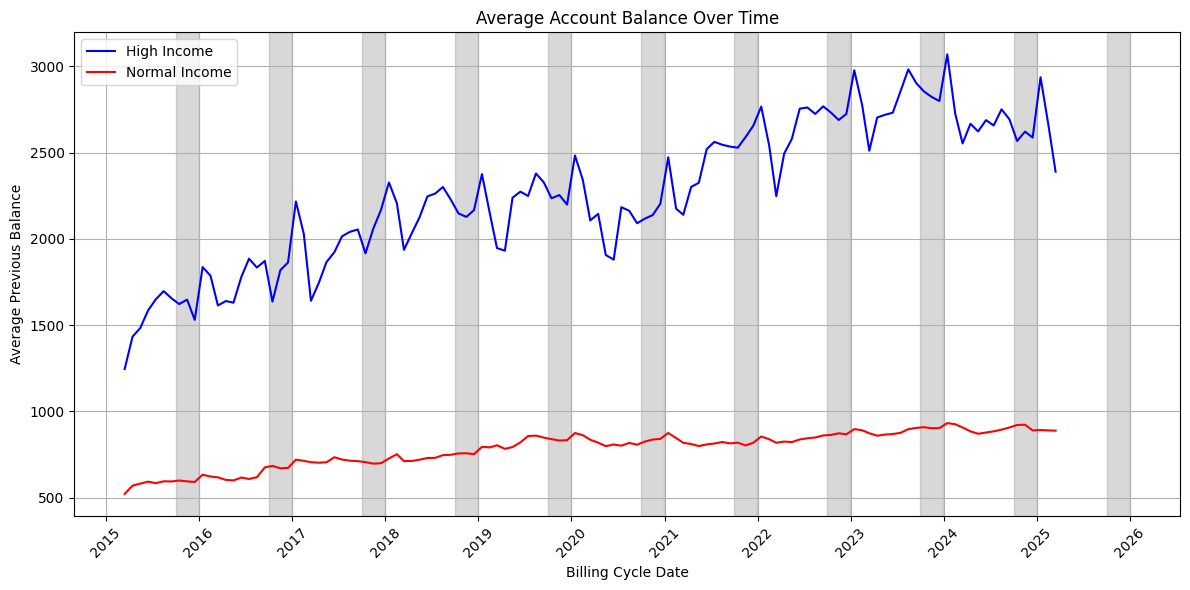

In [93]:


fig, ax = plt.subplots(figsize=(12, 6))

# Plot high-income and normal-income account balances
ax.plot(df_high_grouped.index, df_high_grouped['prev_balance'], label='High Income', color='blue')
ax.plot(df_non_high_grouped.index, df_non_high_grouped['prev_balance'], label='Normal Income', color='red')

# Format x-axis to show years
ax.xaxis.set_major_locator(mdates.YearLocator()) 
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Shade the last three months of each year
for year in df_high_grouped.index.year.unique():
    start_date = pd.Timestamp(f"{year}-10-01")
    end_date = pd.Timestamp(f"{year}-12-31") 
    ax.axvspan(start_date, end_date, color='grey', alpha=0.3) 

ax.set_xlabel('Billing Cycle Date')
ax.set_ylabel('Average Previous Balance')
ax.set_title('Average Account Balance Over Time')

ax.grid(True)
ax.legend()
plt.xticks(rotation=45) 
plt.tight_layout()

plt.savefig('./visualizations/account_balance_high_normal.png', dpi=300)
plt.show()

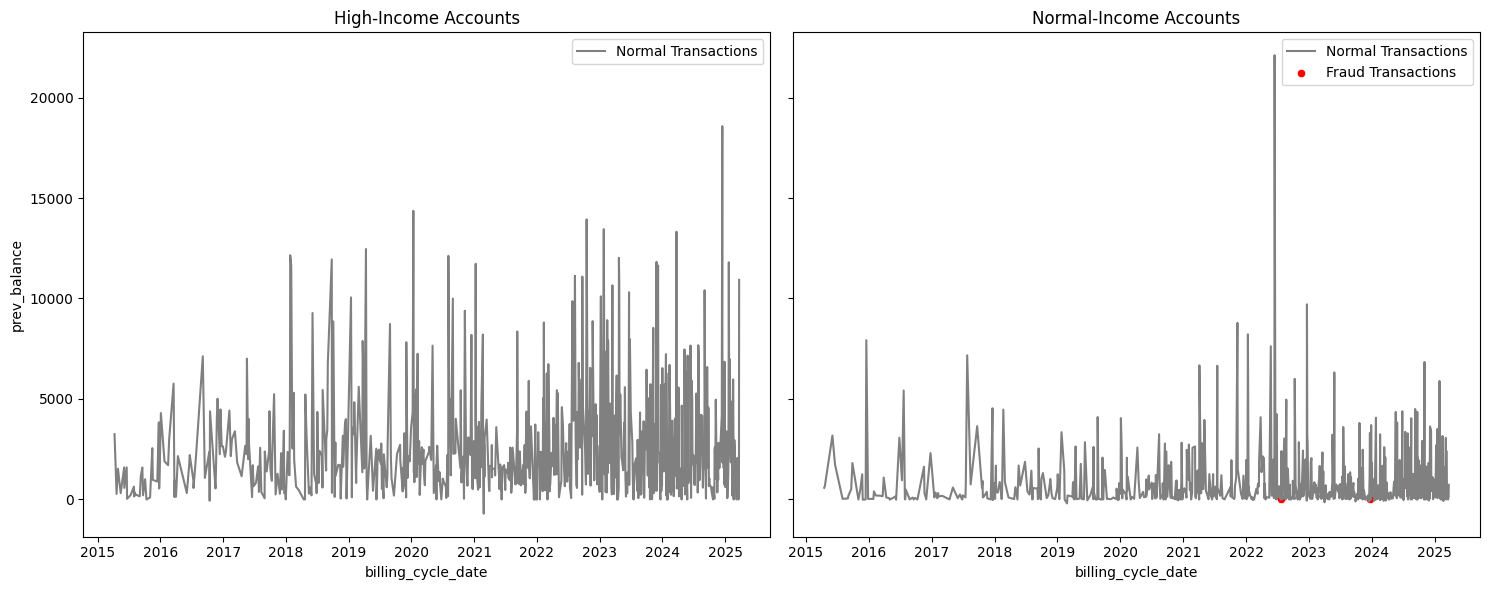

In [94]:
df_fraud = pd.read_csv('exploratory_data_analysis/master_user_dataset_with_predictions.csv')
df_syf = pd.read_csv('cleaned_data/cleaned_syf_id.csv')
df_statements = pd.read_csv('cleaned_data/cleaned_statement_fact.csv')
df_high_income = pd.read_csv('cleaned_data/cleaned_account_dim.csv')

df_merged = df_statements.merge(df_high_income[['current_account_nbr', 'is_high_income']], on='current_account_nbr', how='left')
df_merged = df_merged.merge(df_syf[['account_nbr_pty', 'ds_id']], left_on='current_account_nbr', right_on='account_nbr_pty', how='left')
df_merged.rename(columns={'ds_id': 'user_id'}, inplace=True)
df_merged = df_merged.merge(df_fraud[['user_id', 'has_fraud']], on='user_id', how='left')


df_merged['billing_cycle_date'] = pd.to_datetime(df_merged['billing_cycle_date'], utc=True)
df_merged.drop(columns=['account_nbr_pty'], inplace=True)


# Sample 1000 entries from each group
df_high_sample = df_merged[df_merged['is_high_income'] == 1].sample(1000, random_state=42)
df_non_high_sample = df_merged[df_merged['is_high_income'] == 0].sample(1000, random_state=42)

# Group by date to compute mean balance
df_high_grouped = df_high_sample.groupby('billing_cycle_date').agg({'prev_balance': 'mean', 'has_fraud': 'max'}).reset_index()
df_non_high_grouped = df_non_high_sample.groupby('billing_cycle_date').agg({'prev_balance': 'mean', 'has_fraud': 'max'}).reset_index()

df_high_fraud = df_high_grouped[df_high_grouped['has_fraud'] == 1]
df_non_high_fraud = df_non_high_grouped[df_non_high_grouped['has_fraud'] == 1]

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

# High-income group
sns.lineplot(data=df_high_grouped, x='billing_cycle_date', y='prev_balance', ax=ax[0], color='grey', label="Normal Transactions")

if not df_high_fraud.empty:
    sns.scatterplot(data=df_high_fraud, x='billing_cycle_date', y='prev_balance', ax=ax[0], color='red', label="Fraud Transactions")

ax[0].set_title("High-Income Accounts")

# Normal-income group
sns.lineplot(data=df_non_high_grouped, x='billing_cycle_date', y='prev_balance', ax=ax[1], color='grey', label="Normal Transactions")

if not df_non_high_fraud.empty:
    sns.scatterplot(data=df_non_high_fraud, x='billing_cycle_date', y='prev_balance', ax=ax[1], color='red', label="Fraud Transactions")

ax[1].set_title("Normal-Income Accounts")

plt.tight_layout()
plt.show()

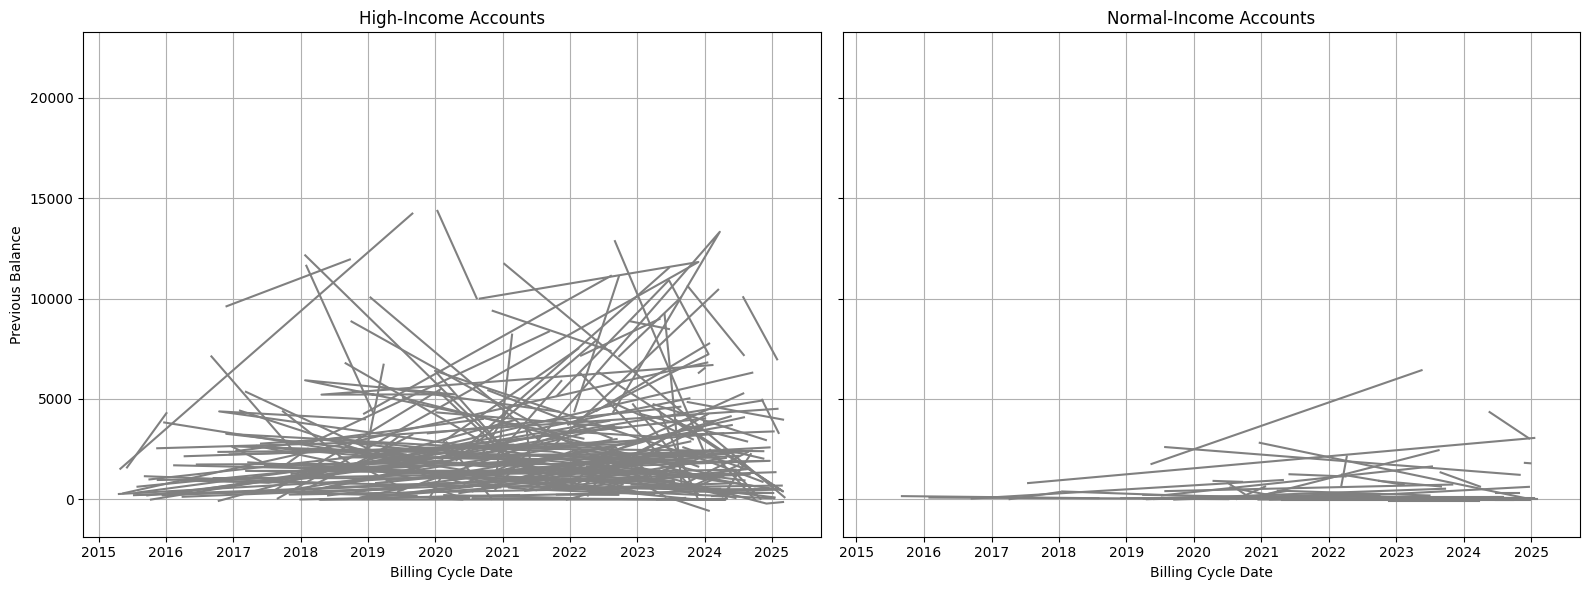

In [95]:
df_merged['billing_cycle_date'] = pd.to_datetime(df_merged['billing_cycle_date'], utc=True)

df_high_sample = df_merged[df_merged['is_high_income'] == 1].sample(1000, random_state=42)
df_non_high_sample = df_merged[df_merged['is_high_income'] == 0].sample(1000, random_state=42)

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# High-income accounts
axes[0].set_title("High-Income Accounts")
for account in df_high_sample['current_account_nbr'].unique():
    account_data = df_high_sample[df_high_sample['current_account_nbr'] == account]
    # Check if the account has fraud
    if account_data['has_fraud'].max() == 1:  # Fraud flagged for this account
        axes[0].plot(account_data['billing_cycle_date'], account_data['prev_balance'], color='red', label=f'Account {account}' if account_data['has_fraud'].max() == 1 else "")
    else:
        axes[0].plot(account_data['billing_cycle_date'], account_data['prev_balance'], color='grey', label=f'Account {account}')

axes[0].set_xlabel("Billing Cycle Date")
axes[0].set_ylabel("Previous Balance")
axes[0].grid(True)

# Normal-income accounts
axes[1].set_title("Normal-Income Accounts")
for account in df_non_high_sample['current_account_nbr'].unique():
    account_data = df_non_high_sample[df_non_high_sample['current_account_nbr'] == account]
    # Check if the account has fraud
    if account_data['has_fraud'].max() == 1:  # Fraud flagged for this account
        axes[1].plot(account_data['billing_cycle_date'], account_data['prev_balance'], color='red', label=f'Account {account}' if account_data['has_fraud'].max() == 1 else "")
    else:
        axes[1].plot(account_data['billing_cycle_date'], account_data['prev_balance'], color='grey', label=f'Account {account}')

axes[1].set_xlabel("Billing Cycle Date")
axes[1].grid(True)

plt.tight_layout()
plt.show()

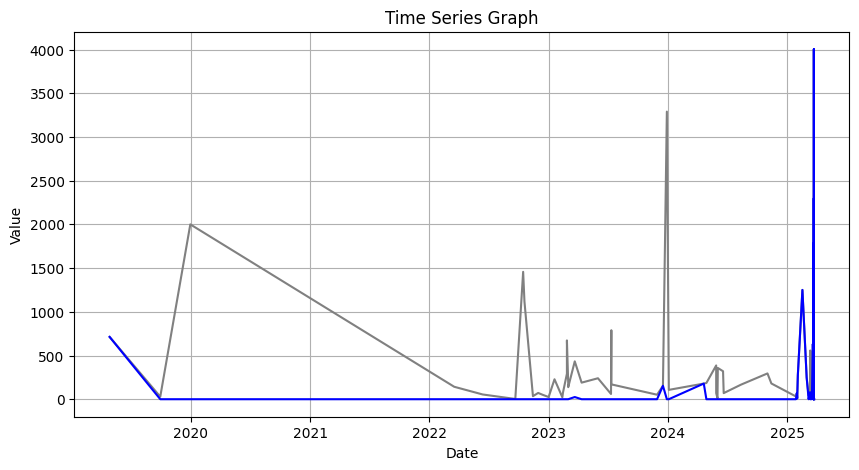

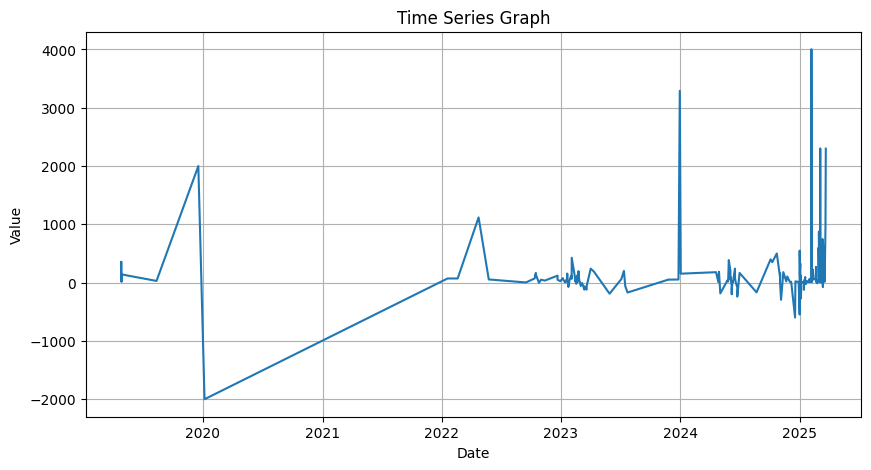

In [96]:
# Size of fraud cases through time series 
df_case = pd.read_csv('cleaned_data/cleaned_fraud_claim.csv')
cols_to_replace = ['reported_date', 'open_date', 'reopen_date', 'close_date']
for col in cols_to_replace:
    df_case[col] = pd.to_datetime(df_case[col], utc=True)

df_case = df_case.sort_values("reported_date", ascending=True)

df_case.dtypes
plt.figure(figsize=(10,5))

# plotting gross fraud & net fraud amount
plt.plot(df_case['reported_date'], df_case['gross_fraud_amt'], label='Gross Fraud Amount', color='grey')
plt.plot(df_case['reported_date'], df_case['net_fraud_amt'], label='Net Fraud Amount', color='blue')

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Time Series Graph')
plt.grid(True)
plt.show()

# Size of fraud transactions through time series 
df_tran = pd.read_csv('cleaned_data/cleaned_fraud_tran.csv')
cols_to_replace = ['transaction_dt']
for col in cols_to_replace:
    df_tran[col] = pd.to_datetime(df_tran[col], utc=True)

df_tran = df_tran.sort_values('transaction_dt', ascending=True)

df_tran.dtypes
plt.figure(figsize=(10,5))
plt.plot(df_tran['transaction_dt'], df_tran['transaction_am']) 
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Time Series Graph')
plt.grid(True)
plt.show()